In [1]:
from collections import defaultdict

import requests

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def do_request(service, a1=None, a2=None, a3=None, **kwargs):
    server = 'http://api.gbif.org/v1'
    params = ''
    for a in [a1, a2, a3]:
        if a is not None:
            params += '/' + a
    req = requests.get('%s/%s%s' % (server, service, params),
                       params=kwargs,
                       headers={'Content-Type': 'application/json'})
    if not req.ok:
        req.raise_for_status()
    return req.json()

In [3]:
req = do_request('species', 'search', q='bear')
print(req['count'])
req['results'][0]

19154


{'key': 9701974,
 'datasetKey': 'd7dddbf4-2cf0-4f39-9b2a-bb099caae36c',
 'constituentKey': 'e01b0cbb-a10a-420c-b5f3-a3b20cc266ad',
 'parentKey': 9661213,
 'parent': 'Mammarenavirus',
 'kingdom': 'Viruses',
 'family': 'Arenaviridae',
 'genus': 'Mammarenavirus',
 'species': 'Bear Canyon mammarenavirus',
 'kingdomKey': 8,
 'familyKey': 6230,
 'genusKey': 9661213,
 'speciesKey': 9701974,
 'scientificName': 'Bear Canyon mammarenavirus',
 'authorship': '',
 'nameType': 'VIRUS',
 'taxonomicStatus': 'ACCEPTED',
 'rank': 'SPECIES',
 'origin': 'SOURCE',
 'numDescendants': 0,
 'numOccurrences': 0,
 'habitats': [],
 'nomenclaturalStatus': [],
 'threatStatuses': [],
 'descriptions': [],
 'vernacularNames': [],
 'higherClassificationMap': {'8': 'Viruses',
  '6230': 'Arenaviridae',
  '9661213': 'Mammarenavirus'},
 'synonym': False}

In [4]:
req_short = do_request('species', 'search', q='bear', rank='family')
print(req_short['count'])
bear = req_short['results'][0]
bear

389


{'key': 121515844,
 'datasetKey': 'c33ce2f2-c3cc-43a5-a380-fe4526d63650',
 'nubKey': 9681,
 'parentKey': 121513412,
 'parent': 'Arctoidea',
 'phylum': 'Chordata',
 'order': 'Carnivora',
 'phylumKey': 121445866,
 'classKey': 121453723,
 'orderKey': 121507052,
 'scientificName': 'Ursidae Gray, 1825',
 'canonicalName': 'Ursidae',
 'authorship': 'Gray, 1825',
 'nameType': 'SCIENTIFIC',
 'taxonomicStatus': 'ACCEPTED',
 'rank': 'FAMILY',
 'origin': 'SOURCE',
 'numDescendants': 153,
 'numOccurrences': 0,
 'extinct': False,
 'habitats': [],
 'nomenclaturalStatus': [],
 'threatStatuses': [],
 'descriptions': [],
 'vernacularNames': [{'vernacularName': 'bear', 'language': 'eng'}],
 'higherClassificationMap': {'121445866': 'Chordata',
  '121453723': 'Mammalia',
  '121507052': 'Carnivora',
  '121513412': 'Arctoidea'},
 'synonym': False,
 'class': 'Mammalia'}

In [5]:
import time
def get_all_records(rec_field, service, a1=None, a2=None, a3=None, **kwargs):
    records = []
    all_done = False
    offset = 0
    num_iter = 0
    while not all_done and num_iter < 100:  # arbitrary
        req = do_request(service, a1=a1, a2=a2, a3=a3, offset=offset, **kwargs)
        all_done = req['endOfRecords']
        if not all_done:
            time.sleep(1)
        offset += req['limit']
        records.extend(req[rec_field])
        num_iter += 1
    return records

In [6]:
#XXX
def get_leaves(nub):
    leaves = []
    recs = get_all_records('results', 'species', str(nub), 'children')
    if len(recs) == 0:
        return None
    for rec in recs:
        if 'nubKey' not in rec:  # XXX why?
            continue
        rec_leaves = get_leaves(rec['nubKey'])
        if rec_leaves is None:
            leaves.append(rec)
        else:
            leaves.extend(rec_leaves)
    return leaves

In [7]:
records = get_all_records('results', 'species', str(bear['nubKey']), 'children')
leaves = get_leaves(bear['nubKey'])

In [8]:
#[leaf['nameType'] for leaf in leaves]
for rec in leaves:
    print(rec['scientificName'], rec['rank'], end=' ')
    vernaculars = do_request('species', str(rec['nubKey']), 'vernacularNames', language='en')['results']
    for vernacular in vernaculars:
        if vernacular['language'] == 'eng':
            print(vernacular['vernacularName'], end='')
            break
    print()

Agriarctos Kretzoi, 1942 GENUS 
Ailurarctos Qiu Zhanxiang & Qi Guoquin, 1989 GENUS 
Ailuropoda microta Pei, 1962 SPECIES 
Cynodon helveticus (Rütimeyer, 1862) SPECIES 
Arctodus pristinus Leidy, 1854 SPECIES 
Arctodus simus SPECIES giant short-faced bear
Harpaleocyon Hürzeler, 1944 GENUS 
Helarctos malayanus euryspilus Horsfield, 1825 SUBSPECIES 
Helarctos malayanus malayanus SUBSPECIES 
Indarctos anthracitis Weithofer, 1888 SPECIES 
Indarctos arctoides Deperet, 1895 SPECIES 
Indarctos atticus Weithofer, 1888 SPECIES 
Indarctos nevadensis Macdonald, 1959 SPECIES 
Indarctos oregonensis Merriam & al., 1925 SPECIES 
Indarctos salmontanus Pilgrim, 1913 SPECIES 
Indarctos vireti Villalta & Crusafont, 1943 SPECIES 
Indarctos zdanskyi Qiu & Tedford, 2003 SPECIES 
Melursus ursinus inornatus Pucheran, 1855 SUBSPECIES 
Melursus ursinus ursinus SUBSPECIES 
Metarctos Gaudry, 1860 GENUS 
Phoberocyon huerzeleri Ginsburg, 1955 SPECIES 
Plionarctos edensis Frick, 1926 SPECIES 
Plionarctos harroldorum T

In [9]:
basis_of_record = defaultdict(int)
country = defaultdict(int)
zero_occurrences = 0
count_extinct = 0
for rec in leaves:
    #print(rec['scientificName'], rec['rank'], rec['taxonID'])
    occurrences = get_all_records('results', 'occurrence', 'search', taxonKey=rec['nubKey'])
    for occurrence in occurrences:
        basis_of_record[occurrence['basisOfRecord']] += 1
        country[occurrence.get('country', 'NA')] += 1
        #there is also publisingCountry
    if len(occurrences) > 0:
        zero_occurrences += 1
    profiles = do_request('species', str(rec['nubKey']), 'speciesProfiles')['results']
    for profile in profiles:
        if profile.get('extinct', False):
            count_extinct += 1
            break

Text(0.5,1,'Status for each species')

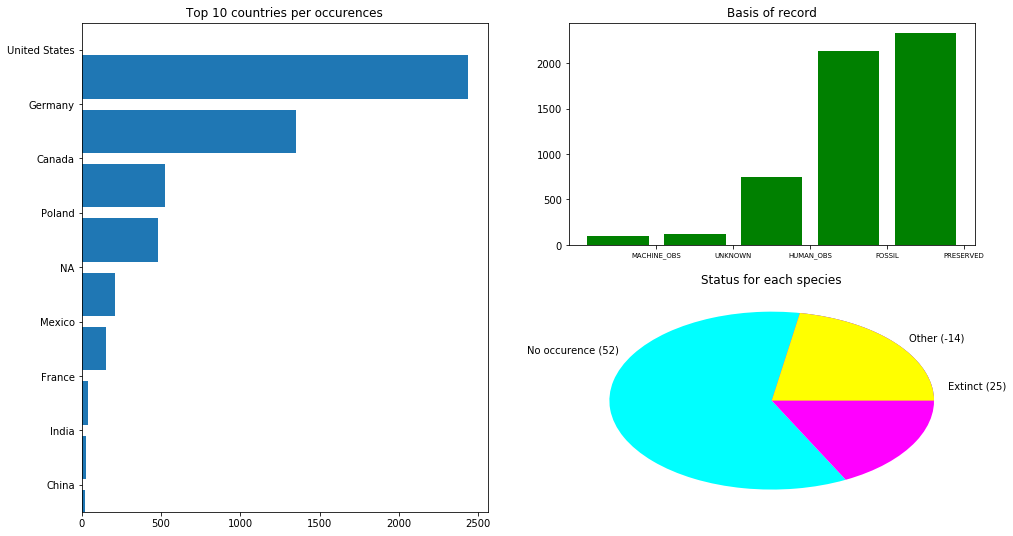

In [10]:
countries, obs_countries = zip(*sorted(country.items(), key=lambda x: x[1]))
basis_name, basis_cnt = zip(*sorted(basis_of_record.items(), key=lambda x: x[1]))
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 2, 1)
ax.barh(np.arange(10) - 0.5, obs_countries[-10:])
ax.set_title('Top 10 countries per occurences')
ax.set_yticks(range(10))
ax.set_ylim(0.5, 9.5)
ax.set_yticklabels(countries[-10:])
#refer metadata problems

ax = fig.add_subplot(2, 2, 2)
ax.set_title('Basis of record')
ax.bar(np.arange(len(basis_name)), basis_cnt, color='g')
basis_name = [x.replace('OBSERVATION', 'OBS').replace('_SPECIMEN', '') for x in basis_name]
ax.set_xticks(0.5 + np.arange(len(basis_name)))
ax.set_xticklabels(basis_name, size='x-small')

ax = fig.add_subplot(2, 2, 4)
other = len(leaves) - zero_occurrences - count_extinct
pie_values = [zero_occurrences, count_extinct, other]
labels = ['No occurence (%d)' % zero_occurrences,
          'Extinct (%d)' % count_extinct, 'Other (%d)' % other]
ax.pie(pie_values, labels=labels,
       colors=['cyan', 'magenta', 'yellow'])
ax.set_title('Status for each species')

In [11]:
#distribution of observations of horribilis per year
#probably not put...

In [12]:
horribilis = get_all_records('results', 'occurrence', 'search', taxonKey=6163845)

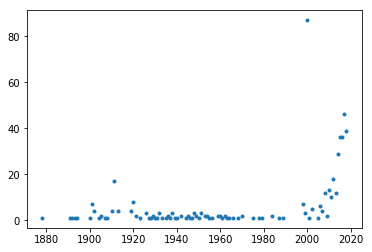

In [13]:
years = defaultdict(int)
for x in horribilis:
    years[x.get('year', None)] += 1
xs, ys = zip(*[(y, cnt) for y, cnt in years.items() if y is not None])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xs, ys, '.')